# Spotify Recommendation System

## 02 Data CLustering and Cluster Insights Extraction

**Project:** Code Institute – Hackathon

---
### **Objectives**
- Final data check + further engineering if necessary
- Run clustering model
- Obtain labels
- Extract insights from labels

### **Inputs**
- `data/processed/cleaned_spotify_dataset.csv`

### **Outputs**
- `data/labelled/label_spotify_dataset.csv`
- Set of insights
- Set of figures
        
### **Additional Comments**

<ins>**Why K-Means**</ins>
- Very good with continuous audio features (our dataset is almost all continuous)
- It finds centroids, which can then be easily mapped to user preferences
- Produced stable, interpretable and easily learnable cluster boundaries

*Alternatives*
1. Gaussian Mixture Models (GMM) - more precise than k-Means and cand create soft boundaries, i.e. a song can be part chil part party. But clusters are less stable than k-Means.
2. HDBSCAN - better for exploration as it finds k (i.e. number of clusters) on its own. However, it is more computationally expensive, and its resulting clusters are volatile (i.e. you may get different clusters each time you run it),

# Data Inspection

In [15]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings 
# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

# for clustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import joblib

# for cluster insight extraction
from sklearn.preprocessing import MinMaxScaler

Set the home directory. Access the current directory with os.getcwd()

In [16]:
PROJECT_DIR = os.path.join(os.getcwd()) # Define the project root directory
os.chdir(PROJECT_DIR) # Change the current working directory

Load the data from the cleaned data set, lcoated within data directory under data/processed/ directory. 

In [17]:
# LOAD DATASET
try:
    # Data directory paths
    data_path = os.path.join("..","data", "processed")
    # Extract the cleaned dataset
    df = pd.read_csv(os.path.join(data_path, "cleaned_spotify_dataset.csv"))
    print("Dataset loaded successfully.")
except Exception as e:
    print(e)
    print("Error loading the dataset.")
    df = pd.DataFrame()  # Create an empty DataFrame if loading fails

print(f"Cleaned dataset shape: {df.shape}")

Dataset loaded successfully.
Cleaned dataset shape: (109607, 21)


In [18]:
# Display the first few rows of the dataset
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [19]:
# check if index is continuous
all(df.index == range(len(df)))

True

In [20]:
# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109607 entries, 0 to 109606
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        109607 non-null  int64  
 1   track_id          109607 non-null  object 
 2   artists           109607 non-null  object 
 3   album_name        109607 non-null  object 
 4   track_name        109607 non-null  object 
 5   popularity        109607 non-null  int64  
 6   duration_ms       109607 non-null  int64  
 7   explicit          109607 non-null  bool   
 8   danceability      109607 non-null  float64
 9   energy            109607 non-null  float64
 10  key               109607 non-null  int64  
 11  loudness          109607 non-null  float64
 12  mode              109607 non-null  int64  
 13  speechiness       109607 non-null  float64
 14  acousticness      109607 non-null  float64
 15  instrumentalness  109607 non-null  float64
 16  liveness          10

In [21]:
# check categorical features unique values
for col in ['explicit', 'key', 'mode', 'time_signature', 'track_genre']:
    unique_values = df[col].nunique()
    print(f"Column '{col}' has {unique_values} unique values.")

Column 'explicit' has 2 unique values.
Column 'key' has 12 unique values.
Column 'mode' has 2 unique values.
Column 'time_signature' has 5 unique values.
Column 'track_genre' has 110 unique values.


# Data preprocessing

<ins>**k-Means**</ins> has a set of <ins>expectations</ins> regarding the dataset that must not be violated.

1. Dataset inhabits a continuous vector space, where Euclidean distance (what it uses to decide how close to points are) makes sense. Basically, this means that no single feature should dominate in scale.
2. Numeric features are required. Categorical variables need encoding.
3. No major outliers, though k-Means can deal with light outliers. The cleaning process should have eliminated the most obvious outliers, so no action will be taken here.
4. Keep dimensionality and multicollinearity low.

<ins>**Pre-processing Tasks**</ins>
1. Rescale
2. Encode variables 'explicit', 'key', 'mode', 'time_signature'. Drop variable 'track_genre' as it contains too many unique values (110), which have no ordinal meaning
3. Perform PCA or similar feature reduction methods
4. Drop columns with no predictive value: 'Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name'

In [1]:
# copy the dataframe for preprocessing
X = df.copy()

NameError: name 'df' is not defined

In [ ]:
# drop columns
X.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'], inplace=True)

In [ ]:
# check the values of the categorical features
for col in ['explicit', 'mode', 'time_signature', 'key']:
    print(f"Value counts for column '{col}':")
    print(X[col].value_counts())
    print("\n")

Value counts for column 'explicit':
explicit
False    100557
True       9050
Name: count, dtype: int64


Value counts for column 'mode':
mode
1    69403
0    40204
Name: count, dtype: int64


Value counts for column 'time_signature':
time_signature
4    98764
3     8419
5     1586
1      832
0        6
Name: count, dtype: int64


Value counts for column 'key':
key
7     12798
0     12500
2     11133
9     10901
1     10272
11     9041
5      8992
4      8689
6      7633
10     7140
8      7115
3      3393
Name: count, dtype: int64




1. Variables 'explicit' and 'time_signature' both have one of the categories with ~ 90% of the entrie.
=> <ins> delete both</ins>
2. 'mode' can be lest as is. it makes sense as an ordinal variable
3. 'key' does not make sense as an ordinal variable as is, because of how musical keys work
=> need <ins>cyclical encoding</ins>


In [ ]:
# drop cols
X.drop(columns=['explicit', 'time_signature'], inplace=True)

# convert key to cyclical
X["key_sin"] = np.sin(2 * np.pi * X["key"] / 12)
X["key_cos"] = np.cos(2 * np.pi * X["key"] / 12)

# drop original key column
X.drop(columns=['key'], inplace=True)

<ins>On why no further encoding is necessary<ins>
1. 'mode' encoded as 0/1 is already in the best possible form for K-Means. It’s numeric, bounded, and its distance interpretation makes sense. K-Means will treat it as a low-variance dimension, so it won’t overpower the continuous features.

2. the cyclical encoding of 'key' as sine and cosine is also already “K-Means-ready”, the new cols are now continuous and have a meaningful Euclidean distance.

# Clustering Pipeline

We'll now create a pipeline with includes:
1. StandardScaler (Z-transform normalisation)
2. PCA to decorrelate features and smooth noise.
    - use <ins>n_components</ins> = 0.85 this essentially allows the algorith to choose the number of features it creates, it is only forced to cover 85% of variance
3. KMeans algorithm
    - use <ins>k-means++</ins> as centroid selection strategy: centroids are chosen sequentially to be as far away from each other as possible. it improve convergence, reduces the effects of initialisation, and should produce better clusters with fewer restarts
    - use <ins>n_init</ins> = 10, even with k-means++ the algorithm can still converge on a local minima, this ensure that the process is run multiple times with multiple random seeds

In [ ]:
# create the pipeline
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.85, random_state=42)),
        ("kmeans", KMeans(
            n_clusters=2,   # placeholder
            init="k-means++",
            n_init=10,
            random_state=42
        ))
    ]
)

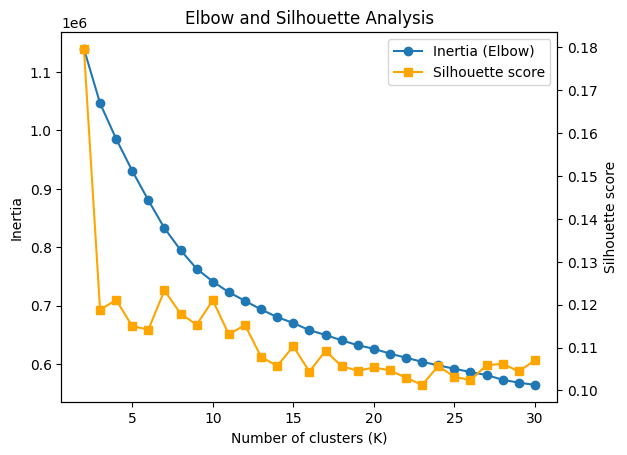

In [ ]:
# create elbow and silhouette plots to help determine optimal K

# define range of K values
Ks = range(2, 31)
sample_size = 10_000   # Silhouette is computationally expensive so we sample
rng = np.random.default_rng(42) # for reproducibility

# lists to store inertia and silhouette scores
inertias = []
silhouettes = []

# iterate over K values
for k in Ks:
    pipeline.set_params(kmeans__n_clusters=k)
    pipeline.fit(X)

    # Elbow (full data)
    inertias.append(pipeline["kmeans"].inertia_)

    # Transform full data once
    X_pca = pipeline["pca"].transform(
        pipeline["scaler"].transform(X)
    )
    labels = pipeline["kmeans"].labels_

    # Silhouette (sampled)
    if len(X_pca) > sample_size:
        idx = rng.choice(len(X_pca), sample_size, replace=False)
        sil = silhouette_score(X_pca[idx], labels[idx])
    else:
        sil = silhouette_score(X_pca, labels)

    silhouettes.append(sil)

# Plot both
fig, ax1 = plt.subplots()

line1, = ax1.plot(Ks, inertias, marker="o", label="Inertia (Elbow)")
ax1.set_xlabel("Number of clusters (K)")
ax1.set_ylabel("Inertia")

ax2 = ax1.twinx()
line2, = ax2.plot(Ks, silhouettes, marker="s", label="Silhouette score", color="orange")
ax2.set_ylabel("Silhouette score")

# add legend and title
ax1.legend(handles=[line1, line2], loc="best")
plt.title("Elbow and Silhouette Analysis")
plt.show()

<ins>**Silhouette vs K Curve Interpretation**</ins>

1. Inertia appears to have a **gentle elbow around 10-12 clusters**, suggesting that:
	- Data has structure (no elbow would indicate randomness)
	- Though there is no sharp natural partition, which makes sense with musical data
	- Past 12 clusters there are diminishing returns
2. Silhouette score has an **early drop, oscillation between 5-17 clusters, then smoothing out**, suggesting:
	- Too few clusters would force dissimilar songs together
	- Oscillations may mean that there are multiple equally plausible ways of partitioning, i.e. cluster boundaries are fuzzy
	- Clusters are becoming small and compact past 17, probably a sign of overclustering

<ins>**Conclusion**</ins>

Further explore Ks between 8 - 12

In [ ]:
# create classic silhouette score plot for optimal K
def plot_silhouette(pipeline, X, K, sample_size=10000, random_state=42):
    """
    Plot silhouette scores for KMeans clustering.
    
    Args:
        pipeline: sklearn Pipeline with scaler, PCA, and KMeans.
        X: Input data (DataFrame or ndarray).
        K: Number of clusters.
        sample_size: Number of samples for silhouette calculation.
        random_state: Random state for reproducibility.

    Returns:
        None (displays plot).
    """
    rng = np.random.default_rng(random_state)

    # Fit pipeline
    pipeline.set_params(kmeans__n_clusters=K)
    pipeline.fit(X)

    # Transform data
    X_pca = pipeline["pca"].transform(
        pipeline["scaler"].transform(X)
    )
    labels = pipeline["kmeans"].labels_

    # Optional sampling
    if len(X_pca) > sample_size:
        idx = rng.choice(len(X_pca), sample_size, replace=False)
        X_pca = X_pca[idx]
        labels = labels[idx]

    # Silhouette values
    sil_values = silhouette_samples(X_pca, labels)
    sil_avg = silhouette_score(X_pca, labels)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 10

    for i in range(K):
        ith_cluster_sil = sil_values[labels == i]
        ith_cluster_sil.sort()

        size_i = ith_cluster_sil.shape[0]
        y_upper = y_lower + size_i

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_sil,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_i, str(i))
        y_lower = y_upper + 10

    ax.axvline(x=sil_avg, color="red", linestyle="--",
               label=f"Average silhouette = {sil_avg:.3f}")

    ax.set_xlabel("Silhouette coefficient")
    ax.set_ylabel("Cluster label")
    ax.set_title(f"Silhouette plot for K = {K}")
    ax.legend(loc="lower right")

    plt.show()

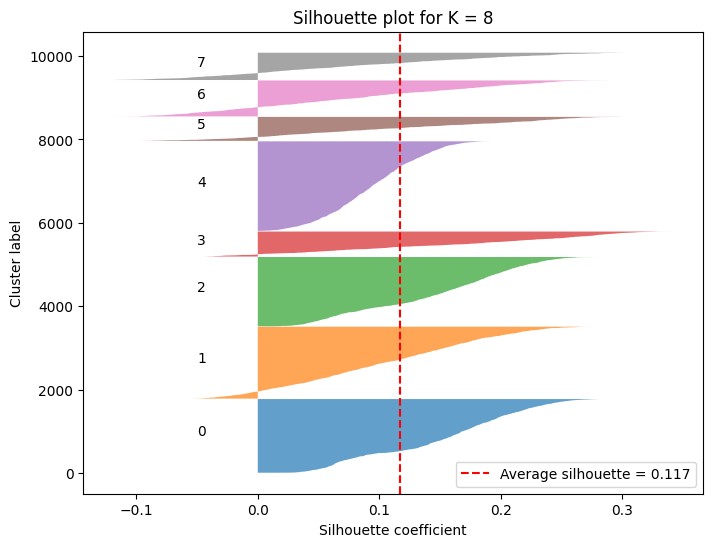

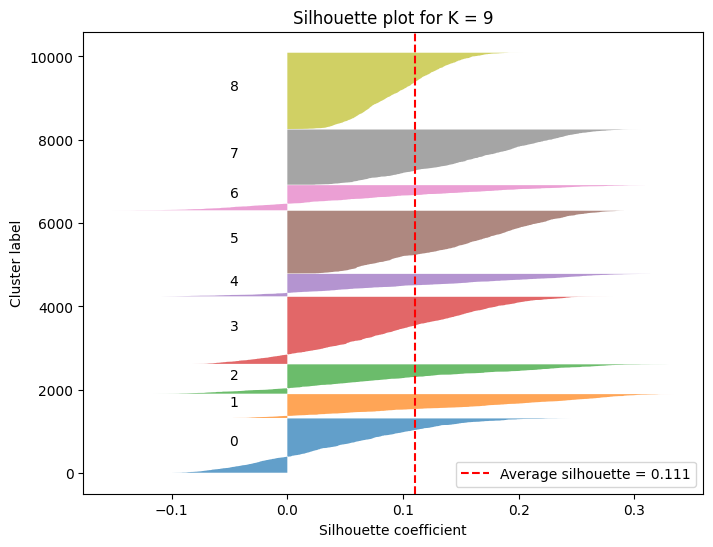

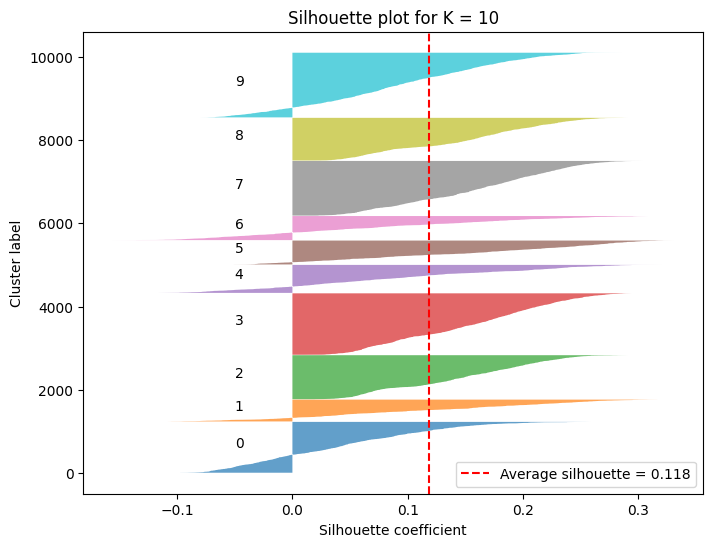

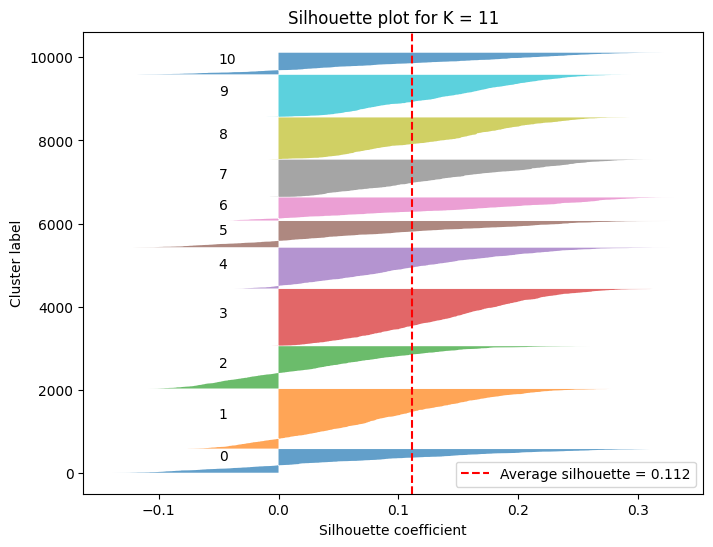

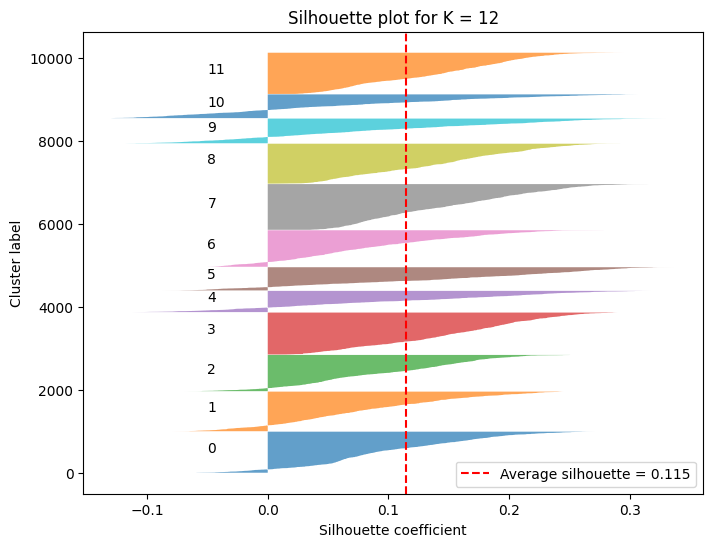

In [ ]:
# plot several K values around the optimal one
for K in [8, 9, 10, 11, 12]:
    plot_silhouette(pipeline, X, K)

<ins>**Interpretation**</ins>

What we are looking for:
1. Cluster bands are mostly to the right of 0
2. Extension to the left of 0 are as thin and short as possible
3. Bands are thick
4. Bands are uniform in height and thickness
5. Gentle sloping right edges
6. The average line is comfortably to the right of 0

<ins>**Conclusion**</ins>

*While K=12 produced slightly finer segmentation, silhouette inspection revealed a small number of internally inconsistent clusters with extended negative silhouettes. K=10 exhibited fewer clusters and more uniform internal coherence, making it better suited to optimise cluster stability, which will help downstream supervised learning, and explainabily.*

In [ ]:
# obtain labels for optimal K
K = 10
pipeline.set_params(kmeans__n_clusters=K)
pipeline.fit(X)

# extract labels
cluster_labels = pipeline["kmeans"].labels_

# attach labels to original dataframe
df["cluster"] = cluster_labels

In [ ]:
# perform sanity check to ensure that no clusters were miss attached
df["cluster"].value_counts().sort_index()
df.groupby("cluster").mean(numeric_only=True)

,Unnamed: 0,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,,,
0,50274.531159,32.274846,228535.076562,0.100356,0.381250,0.853237,5.248786,-5.206477,0.737132,0.089289,0.054635,0.167459,0.215967,0.296221,151.249822,3.895516
1,65023.643654,36.226796,244878.408495,0.044441,0.512461,0.747049,5.265005,-6.931623,0.688422,0.077023,0.304626,0.049584,0.773716,0.513426,123.660494,3.939488
2,57016.456995,36.338870,218418.439370,0.101686,0.647070,0.733976,7.217270,-6.330483,0.000000,0.068027,0.177991,0.070052,0.174941,0.566508,121.260590,3.960342
3,58654.092842,33.213404,214148.374217,0.078476,0.636432,0.724924,7.485412,-6.270060,1.000000,0.061044,0.217209,0.035204,0.172857,0.620894,120.775182,3.965255
4,51288.477044,26.477588,385138.728471,0.023907,0.610570,0.715956,5.623472,-9.168966,0.516572,0.061583,0.089312,0.700067,0.156412,0.307062,126.196065,3.946754
5,51330.321583,25.721088,220383.020254,0.002474,0.357946,0.153553,4.872449,-20.700078,0.617965,0.048994,0.891886,0.740901,0.146609,0.186660,106.286293,3.682746
6,55482.652507,35.397135,193445.360840,0.346354,0.681083,0.682661,5.539225,-6.936956,0.545247,0.321574,0.264773,0.056186,0.205418,0.538453,125.175646,3.994792
7,59057.197609,34.617939,216640.116200,0.081536,0.633258,0.723574,2.489848,-6.344212,1.000000,0.057971,0.200658,0.043844,0.171194,0.602818,119.831546,3.964324
8,57999.514633,36.278073,219168.842774,0.102026,0.633478,0.720035,4.790545,-6.377385,0.000090,0.066338,0.197444,0.061844,0.176287,0.547119,119.529527,3.962810


In [ ]:
# save the pipeline
joblib.dump(pipeline, Path.cwd().parent/'models/kmeans_pipeline_k10.pkl');

# save the labeled dataset
df.to_csv(Path.cwd().parent/'data/labelled/clusters_k10_labels.csv', index=True)

# Cluster Insights

The purpose here is to make sense of the clusters => be able to describe each cluster in terms understandable to the regular user.

In [ ]:
# load the labelled dataset
df = pd.read_csv(Path.cwd().parent/'data/labelled/clusters_k10_labels.csv', index_col=0)
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,2
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,9
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,9
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,9
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,9


## Summary Panel

Firstly, create a summary panel for the clusters in which all variables are aggregated into single values.

This would show the 'essence' of each cluster.

Steps:
1. Processing
    - Drop uninterpretable or un-summarisable columns
    - Convert duration to minutes
    - MinMax normalise the columns which are not directly interpretable (e.g. danceability)
2. Groupby
3. Aggregate

In [8]:
# drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'explicit', 'key', 'time_signature'], inplace=True)

In [14]:
# convert to minutes
df["duration_min"] = df["duration_ms"] / 60000
df.drop(columns=['duration_ms'], inplace=True)

In [18]:
# MinMax scaling

# select columns to normalize
norm_cols = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

# initialize scaler
scaler = MinMaxScaler()

# create normalised dataframe
df_norm = df.copy()
df_norm[norm_cols] = scaler.fit_transform(df[norm_cols])

# convert to percentages for understandability
df_norm[norm_cols] = round(df_norm[norm_cols] * 100, 2)

In [21]:
# save MinMax scaler for consistent intrepretation in future use
joblib.dump(scaler, Path.cwd().parent/'models/minmax_scaler.pkl');

In [19]:
df_norm.head()

,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre,cluster,duration_min
0,73,66.91,46.10,84.65,0,19.10,3.23,0.00,35.20,71.86,27.03,acoustic,2,3.844433
1,55,39.49,16.60,60.79,1,8.56,92.77,0.00,9.26,26.83,22.14,acoustic,9,2.493500
2,57,41.42,35.90,77.86,1,5.31,21.08,0.00,10.88,12.06,21.60,acoustic,9,3.513767
3,71,22.99,5.96,57.88,1,2.24,90.86,0.01,12.39,14.37,71.07,acoustic,9,3.365550
4,82,60.69,44.30,77.98,1,4.82,47.09,0.00,7.43,16.78,42.07,acoustic,9,3.314217


In [20]:
df.columns

Index(['popularity', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'track_genre', 'cluster', 'duration_min'],
      dtype='object')